# Colorization with OpenVINO

This notebook demostrates colorization with OpenVINO. We use the [colorizatioin siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). Given a black and white image, the colorization model can turn it into a plausible color version of the image.


## Imports

In [1]:
import os
import sys

import cv2 as cv
import numpy as np
from openvino.runtime import Core, get_version
from matplotlib import pyplot as plt

sys.path.append("../utils")
from notebook_utils import load_image

## The Model

### Download the Model

`omz_downloader`, a command-line tool from the `openvino-dev` package, can help us download pretrained models easily. 

In [2]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "colorization-siggraph"

download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading colorization-siggraph ||################

========== Downloading model/public/colorization-siggraph/ckpt/colorization-siggraph.pth
... 100%, 133581 KB, 1385 KB/s, 96 seconds passed

========== Downloading model/public/colorization-siggraph/model/__init__.py
... 100%, 0 KB, 250 KB/s, 0 seconds passed

========== Downloading model/public/colorization-siggraph/model/base_color.py
... 100%, 0 KB, 1623 KB/s, 0 seconds passed

========== Downloading model/public/colorization-siggraph/model/siggraph17.py
... 100%, 7 KB, 18678 KB/s, 0 seconds passed

========== Replacing text in model/public/colorization-siggraph/model/__init__.py



### Convert the Model

The pre-trained model is in PyTorch format. We will use Model Converter (`omz_converter`) to convert it to OpenVINO IR format. `omz_converter`, which is also a command-line tool from the `openvino-dev` package, can help us convert different models to OpenVINO IR format easily. If the converted model already exists, then the conversion step will be skipped and there will be no output from this step.

In [3]:
# FP16 is also available
precision = "FP32"

# output path for the conversion
converted_model_path = f"model/public/{model_name}/{precision}/{model_name}.xml"

if not os.path.exists(converted_model_path):
    convert_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    ! $convert_command

========== Converting colorization-siggraph to ONNX
Conversion to ONNX command: /home/percent1/anaconda3/envs/openvino/bin/python -- /home/percent1/anaconda3/envs/openvino/lib/python3.8/site-packages/openvino/model_zoo/internal_scripts/pytorch_to_onnx.py --model-path=model/public/colorization-siggraph --model-name=SIGGRAPHGenerator --weights=model/public/colorization-siggraph/ckpt/colorization-siggraph.pth --import-module=model '--input-shapes=[1,1,256,256],[1,2,256,256],[1,1,256,256]' --output-file=model/public/colorization-siggraph/colorization-siggraph.onnx --input-names=data_l,user_ab,user_map --output-names=color_ab

ONNX check passed successfully.

========== Converting colorization-siggraph to IR (FP32)
Conversion command: /home/percent1/anaconda3/envs/openvino/bin/python -- /home/percent1/anaconda3/envs/openvino/bin/mo --framework=onnx --data_type=FP32 --output_dir=model/public/colorization-siggraph/FP32 --model_name=colorization-siggraph '--input_shape=[1,1,256,256],[1,2,256,2

## Load the Model



In [4]:
# load the inference engine, read model and compile model

ie_core = Core()
model = ie_core.read_model(model=converted_model_path)
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

## Processing and utility function

In [5]:
def preprocess(img, W, H):
    """
    convert RGB-image to LAB-image, resize to (W, H)
    return LAB-image, L-channel of LAB-image(resized)
    """
    img_rgb = img.astype(np.float32) / 255
    img_lab = cv.cvtColor(img_rgb, cv.COLOR_RGB2Lab)
    img_l_channel = cv.resize(img_lab.copy(), (W, H))[:, :, 0]
    return img_lab, img_l_channel

def postprocess(img, img_lab, W, H):
    """
    process the output of inference, 
    img is a LAB-image with only AB-channel.
    return BGR-image
    """
    # (B, C, H, W) -> (C, H, W), when B = 1
    img = np.squeeze(img)
    # (C, H, W) -> (H, W, C)
    img = img.transpose((1, 2, 0))
    img = cv.resize(img, (W, H))
    img_lab_full = np.concatenate((img_lab[:, :, 0][:, :, np.newaxis], img), axis=2)
    img_bgr = np.clip(cv.cvtColor(img_lab_full, cv.COLOR_Lab2BGR), 0, 1)
    img_bgr = (img_bgr * 255).astype(np.uint8)
    return img_bgr

def show_input_output_image(input_image, output_image):
    """
    show input image and output image
    """
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(input_image)
    plt.axis('off')
    plt.title("Input")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(output_image)
    plt.axis('off')
    plt.title("Output")

## Run Inference

To run inference, we need to create infer request. `colorization-siggraph` model takes 3 inputs: `data_l`, `user_ab`, `user_map`, we  don't need to specify all three inputs to use the model. We can set the input `data_l` to the preprocessed image, and the remaining inputs `user_ab`, `user_map` to zeros. We can call request.infer() method to run inference, then get output from result tensors.

In [6]:
input_tensor_name = 'data_l'
output_tensor = compiled_model.outputs[0]

inputs = {}
for input in model.inputs:
    inputs[input.get_any_name()] = np.zeros(input.shape)
inputs.keys()

dict_keys(['data_l', 'user_ab', 'user_map'])

In [7]:
def colorize(image_path):
    """
    image_path can be local path or URL
    """
    H, W = 256, 256
    image = load_image(image_path)
    (h, w, c) = image.shape
    img_lab, img_l_channel = preprocess(image, W, H)
    inputs[input_tensor_name] = np.expand_dims(img_l_channel, axis=[0, 1])

    # create infer request and perform inference
    infer_request = compiled_model.create_infer_request()
    res = infer_request.infer(inputs)[output_tensor]

    out = postprocess(res, img_lab, w, h)
    show_input_output_image(cv.cvtColor(image, cv.COLOR_BGR2RGB), cv.cvtColor(out, cv.COLOR_BGR2RGB))

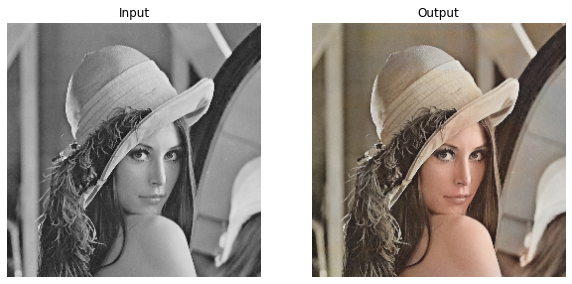

In [8]:
colorize('lena.png')

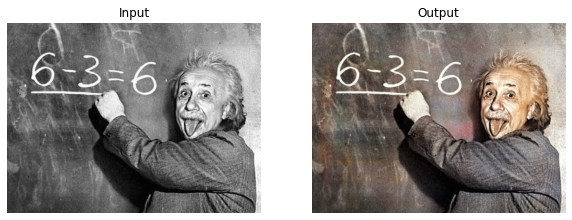

In [9]:
colorize('einstein.jpeg')

## References

1. [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)
2. [colorization-siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph)
3. [Real-Time User-Guided Image Colorization with Learned Deep Priors](https://arxiv.org/abs/1705.02999)